# Import Libraries

In [3]:
import pandas as pd
import numpy as np

# Random Forest for Regression

Using the CTR (click-through rate) dataset, we are going to predict CTR on 6,057 new advertisements shown in a specified position on the (former) Tencent search engine.

* Dependent Variable: Click-through rate (CTR), proportion of times that a type of user clicks on an ad each time it is displayed based on position, keyword, geographic area, user profile, device, etc.
* Prediction Variables (Independent Variable):
  * titleWords: number of words in the title of the ad
  * adWords: number of words in the text of the ad
  * depth: number of ads on the page
  * position: where the ad is on the page
  * advCTR: average CTR of this advertiser's ads across all ads
  * advCTRInPos: average CTR of this advertiser's ads across all ads in this position
  * queryCTR: average CTR of this query from the user across all ads
  * queryCTRInPos: average CTR of this query from the user across all ads in this position
  * gender & age: of the users viewing the advertisement

## Load Data

As always remember to upload your dataset files first. 

In [5]:
ctr = pd.read_csv('CTR.csv')
ctr

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24
...,...,...,...,...,...,...,...,...,...,...,...
6052,0.0182,8,16,1,1,0.0273,0.0356,0.0040,0.0000,unknown,unknown
6053,0.0536,6,20,1,1,0.0919,0.0982,0.0000,0.0000,female,19-24
6054,0.0141,9,26,3,1,0.0496,0.0523,0.0467,0.0668,unknown,unknown
6055,0.1339,9,16,2,1,0.0566,0.0610,0.0618,0.1012,unknown,unknown


Upon first look we see that: 

1. we have some string entries, which we would have to encode
2. we also have some unknown values in `gender` and `age`, which we probably want to handle otherwise they will be encoded as well. 

## Feature Engineering

First we convert `gender` and `age` to categories.

In [6]:
for col in ['gender', 'age']:
  ctr[col] = ctr[col].astype('category')

In [7]:
ctr.dtypes

CTR               float64
titleWords          int64
adWords             int64
depth               int64
position            int64
advCTR            float64
advCTRInPos       float64
queryCTR          float64
queryCTRInPos     float64
gender           category
age              category
dtype: object

### Handling the unknown

We have several appraoch that we can take for handling unknown values: 

Option #1 

We can drop them directly: this is very straightforward, but it will decrease the number of observations in our dataset, which might not be ideal in every situation. In our case dropping all the `unknown` in `gender` and `age` reduced our dataset size from over 6k rows to only over 2k observations. 

In [9]:
ctr = ctr[ctr['gender'] != 'unknown']
ctr

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24
...,...,...,...,...,...,...,...,...,...,...,...
6044,0.0413,7,25,1,1,0.0240,0.0290,0.0114,0.0170,male,13-18
6045,0.0373,13,25,1,1,0.0191,0.0243,0.0000,0.0000,male,25-30
6047,0.0976,3,22,2,1,0.0160,0.0179,0.0483,0.1221,male,13-18
6051,0.0000,10,15,3,2,0.0292,0.0303,0.0145,0.0136,male,19-24


In [10]:
ctr = ctr[ctr['age'] != 'unknown']
ctr

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24
...,...,...,...,...,...,...,...,...,...,...,...
6044,0.0413,7,25,1,1,0.0240,0.0290,0.0114,0.0170,male,13-18
6045,0.0373,13,25,1,1,0.0191,0.0243,0.0000,0.0000,male,25-30
6047,0.0976,3,22,2,1,0.0160,0.0179,0.0483,0.1221,male,13-18
6051,0.0000,10,15,3,2,0.0292,0.0303,0.0145,0.0136,male,19-24


**Option #2**

We can estimate them: this is more appealing and applicable for a numeric value. To estimate the `NaN` values we can use the `sklearn.preprocessing.Imputer` function, which has a couple of ways to estimate the numeric value (for example using the mean of the feature column).

For this exercise, we are going to remove these lines of entry, but remember that this might not be an optimal solution in all situations.  

### Label Encoding

In [11]:
gender_categories = pd.Series(ctr.gender.unique())
age_categories = pd.Series(ctr.age.unique())

In [12]:
gender_categories

0      male
1    female
dtype: category
Categories (3, object): ['female', 'male', 'unknown']

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(gender_categories)
ctr['gender'] = le.transform(ctr['gender'])

In [14]:
ctr

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,1,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,1,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,1,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,0,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,0,19-24
...,...,...,...,...,...,...,...,...,...,...,...
6044,0.0413,7,25,1,1,0.0240,0.0290,0.0114,0.0170,1,13-18
6045,0.0373,13,25,1,1,0.0191,0.0243,0.0000,0.0000,1,25-30
6047,0.0976,3,22,2,1,0.0160,0.0179,0.0483,0.1221,1,13-18
6051,0.0000,10,15,3,2,0.0292,0.0303,0.0145,0.0136,1,19-24


In [15]:
ctr['age'] = LabelEncoder().fit(age_categories).transform(ctr['age'])
ctr

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,1,5
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,1,1
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,1,1
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,0,3
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,0,2
...,...,...,...,...,...,...,...,...,...,...,...
6044,0.0413,7,25,1,1,0.0240,0.0290,0.0114,0.0170,1,1
6045,0.0373,13,25,1,1,0.0191,0.0243,0.0000,0.0000,1,3
6047,0.0976,3,22,2,1,0.0160,0.0179,0.0483,0.1221,1,1
6051,0.0000,10,15,3,2,0.0292,0.0303,0.0145,0.0136,1,2


## Train / Test Split

In [16]:
X_ctr = ctr.loc[:, ctr.columns != 'CTR']
y_ctr = ctr['CTR']

In [17]:
X_ctr

,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,10,17,3,2,0.0136,0.0146,0.0000,0.0000,1,5
1,13,30,2,1,0.0373,0.0465,0.0382,0.0581,1,1
2,12,14,1,1,0.0254,0.0310,0.0255,0.0323,1,1
3,5,19,3,2,0.0178,0.0076,0.0035,0.0017,0,3
4,11,17,2,2,0.0096,0.0069,0.0294,0.0171,0,2
...,...,...,...,...,...,...,...,...,...,...
6044,7,25,1,1,0.0240,0.0290,0.0114,0.0170,1,1
6045,13,25,1,1,0.0191,0.0243,0.0000,0.0000,1,3
6047,3,22,2,1,0.0160,0.0179,0.0483,0.1221,1,1
6051,10,15,3,2,0.0292,0.0303,0.0145,0.0136,1,2


In [18]:
y_ctr

0       0.0000
1       0.0761
2       0.0426
3       0.0000
4       0.0068
         ...  
6044    0.0413
6045    0.0373
6047    0.0976
6051    0.0000
6053    0.0536
Name: CTR, Length: 2624, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split
X_train_ctr, X_test_ctr, y_train_ctr, y_test_ctr = train_test_split(X_ctr, y_ctr, test_size = 0.3, random_state = 123)

## Building a forest of regression!

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf_mod_default = RandomForestRegressor(random_state = 123).fit(X_train_ctr, y_train_ctr)
rf_mod_default.score(X_train_ctr, y_train_ctr)

0.92971253300833

In [21]:
rf_mod_default.score(X_test_ctr, y_test_ctr)

0.5138303452114683

### Variable Importance

We can get the variable importance (called "feature importance") by accessing the `model.feature_importances_`. The feature importances are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

#### Impurity-based Feature Importance

In [22]:
import time
from sklearn import tree

start_time = time.time()
importances = rf_mod_default.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_mod_default.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.021 seconds


In [23]:
feature_names = X_ctr.columns

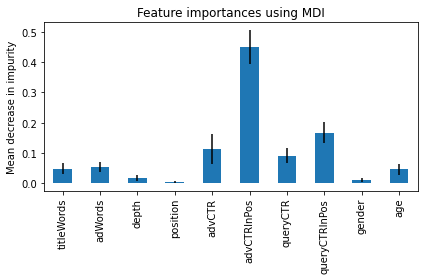

In [24]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Impurity-based feature importances can be misleading for high cardinality features (many unique values). This is most likely true for our case, so we can try using permutation feature importance as an alternative. 

#### Permutation Feature Importance

Read more about permutation feature importance [here](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

In [25]:
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf_mod_default, X_train_ctr, y_train_ctr, n_repeats = 10, random_state = 123, n_jobs=2
)
# here we are calulating the feature importance of the train set so that we can compare it with impurity based feature importance 
# but you can calculate on the test set as well 
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index = feature_names)

Elapsed time to compute the importances: 4.733 seconds


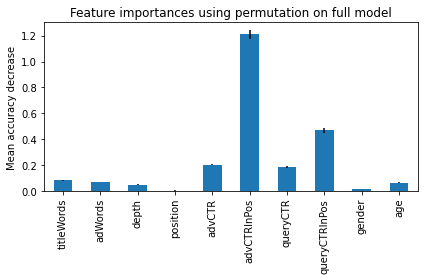

In [26]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

As we can see from the two graphs, while it does change our feature importance, the `advCTRInPos` is still the most important one. `queryCTRInPos` appears more important when using permutation feature importance than impurity-based. 

## Hyper-parameter Tuning using CV

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
# parameters = {"max_depth" : [3,4,5,6,7,8,9,10],
#              "min_samples_split": [10, 20, 30, 40 ],
#              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#              "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#              "max_features":["auto","log2","sqrt",None],
#              "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

parameters = {"max_features": [1, 2, 3, 4, 5, 6, 7]}

While there are a lot of parameters that we can tune for, here to save time, we are only going to replicate the `mtry` tuning that we did in recitation and the corresponding parameter for `mtry` is `max_features`, which stands for the number of features to consider when looking for the best split. 

In [29]:
tuning_model = GridSearchCV(rf_mod_default,
                            param_grid = parameters,
                            scoring='neg_mean_squared_error',
                            cv = 5, 
                            verbose=3)

In [30]:
tuning_model.fit(X_train_ctr, y_train_ctr)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...................max_features=1;, score=-0.003 total time=   0.2s
[CV 2/5] END ...................max_features=1;, score=-0.004 total time=   0.2s
[CV 3/5] END ...................max_features=1;, score=-0.004 total time=   0.2s
[CV 4/5] END ...................max_features=1;, score=-0.005 total time=   0.2s
[CV 5/5] END ...................max_features=1;, score=-0.004 total time=   0.2s
[CV 1/5] END ...................max_features=2;, score=-0.004 total time=   0.2s
[CV 2/5] END ...................max_features=2;, score=-0.004 total time=   0.3s
[CV 3/5] END ...................max_features=2;, score=-0.003 total time=   0.2s
[CV 4/5] END ...................max_features=2;, score=-0.005 total time=   0.3s
[CV 5/5] END ...................max_features=2;, score=-0.004 total time=   0.5s
[CV 1/5] END ...................max_features=3;, score=-0.004 total time=   0.4s
[CV 2/5] END ...................max_features=3;, 

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7]},
             scoring='neg_mean_squared_error', verbose=3)

In [31]:
tuning_model.best_params_

{'max_features': 2}

### Tuned 'Optimal' Model 

In [38]:
rf_optimal = RandomForestRegressor(max_features = 2, random_state = 123).fit(X_train_ctr, y_train_ctr)

In [39]:
rf_optimal.score(X_train_ctr, y_train_ctr)

0.931096140606448

In [40]:
rf_optimal.score(X_test_ctr, y_test_ctr)

0.525303762204492

By just tuning `mtry`, we have an out-of-sample R2 increase from 0.513 -> 0.525. 

# Random Forest for Classification

We have seen how to use CART models and randome forest for regression but they both are known for classification problems, so let's use the `loans` dataset that we have seen in logistic regression and take a look how to use random forest for classification problems. 

### Data Preprocessing

In [41]:
loans = pd.read_csv('loans.csv')

In [42]:
loans.head()

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0


Recall that `default = 0` means that a particular applicant will not default on their loans, `default = 1` means that the applicant will likely to default on loans. 

## Train / Test Split

In [43]:
X_loans = loans.iloc[:, loans.columns != 'default']
y_loans = loans['default']

In [44]:
X_loans.head()

,installment,log_income,fico_score,rev_balance,inquiries,records
0,829,4.93,737,28.85,0,0
1,228,4.81,707,33.62,0,0
2,367,4.51,682,3.51,1,0
3,162,4.93,712,33.67,1,0
4,103,4.91,667,4.74,0,0


In [45]:
y_loans.head()

0    0
1    0
2    0
3    0
4    0
Name: default, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split

X_train_loans, X_test_loans, y_train_loans, y_test_loans = train_test_split(X_loans, y_loans, test_size = 0.3, random_state = 123)

## Building a forest of classifications!

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_mod_class = RandomForestClassifier(random_state = 123,).fit(X_train_loans, y_train_loans)

In [49]:
rf_mod_class.score(X_test_loans, y_test_loans)

0.842031523642732

## Making Predictions

### Getting predicted probablities

In [53]:
rf_mod_class.predict(X_test_loans)

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
rf_mod_class.predict_proba(X_test_loans)

array([[0.77, 0.23],
       [0.93, 0.07],
       [0.69, 0.31],
       ...,
       [0.82, 0.18],
       [0.88, 0.12],
       [0.83, 0.17]])

### Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_loans = rf_mod_class.predict(X_test_loans)

cm = confusion_matrix(y_test_loans, y_pred_loans, labels = rf_mod_class.classes_)
 
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[2385   24]
 [ 427   19]]


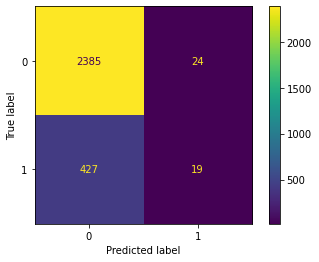

In [52]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_mod_class.classes_)
disp.plot()
plt.show()